In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("chillwise_ac_usage_dataset.csv")
print(df.head())

   Hours_per_day  Temp_set  Room_size  Outside_temp  AC_type  Electricity_cost
0              8        27        109            27      1.0             515.0
1              5        28        257            33      1.5             806.0
2              6        22        252            30      2.0             902.0
3              8        22        202            33      1.0             757.0
4              4        22        183            37      2.0             820.0


In [3]:
from sklearn.metrics import r2_score

In [4]:
from xgboost import XGBRegressor

x_train = df.drop("Electricity_cost",axis=1)
y_train = df["Electricity_cost"]

xgb = XGBRegressor()

xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage 
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools import tool

In [ ]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama3-70b-8192")

In [ ]:
from langchain.tools import tool

@tool
def mlModel(
    Hours_per_day: int,
    Temp_set: int,
    Room_size: int,
    Outside_temp: int,
    AC_type: float
) -> str:
    """
    Predict the electricity cost based on AC usage parameters.

    Args:
        Hours_per_day (int): Number of hours AC is used per day.
        Temp_set (int): Temperature set on the AC.
        Room_size (int): Size of the room in square feet.
        Outside_temp (int): Current outside temperature.
        AC_type (float): AC tonnage (e.g., 1.0, 1.5, 2.0).

    Returns:
        str: Predicted electricity cost in ₹.
    """
    df_test = pd.DataFrame({
        "Hours_per_day": [Hours_per_day],
        "Temp_set": [Temp_set],
        "Room_size": [Room_size],
        "Outside_temp": [Outside_temp],
        "AC_type": [AC_type]
    })
    prediction = xgb.predict(df_test)
    return f"The predicted electricity cost is ₹{prediction[0]:.2f}"


In [ ]:
tools = [mlModel]
tool_calling_llm = llm.bind_tools(tools)
def chat_llm(state: State):
    result = tool_calling_llm.invoke(state["messages"])
    return {"messages": state["messages"] + [result]}  # <-- Append new response

    

In [28]:
def decide_next(state):
    if "tool_call" in state:  # example condillm_with_tooltion
        return "tool"
    return "__end__"

In [29]:
graph_builder = StateGraph(State)
graph_builder.add_node("llm_with_tool", chat_llm)
graph_builder.add_node("tool", ToolNode(tools))

graph_builder.add_edge(START, "llm_with_tool")



# tool always returns to llm_with_tool (never ends)
graph_builder.add_edge("llm_with_tool", "tool")


# Remove this — redundant and might allow accidental END without condition
# graph_builder.add_edge("llm_with_tool", END)

graph = graph_builder.compile()


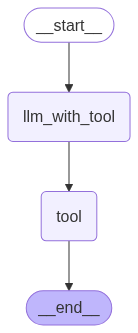

In [30]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
state = {
    "messages": [
        {
            "role": "user",
            "content": "I use my AC for 6 hours a day at 24 degrees. My room is 120 sq ft, the outside temperature is 35°C, and it's a 1.5 ton AC. Can you tell me the electricity cost?"
        }
    ]
}
response = graph.invoke(state)
print(response["messages"])

[HumanMessage(content="I use my AC for 6 hours a day at 24 degrees. My room is 120 sq ft, the outside temperature is 35°C, and it's a 1.5 ton AC. Can you tell me the electricity cost?", additional_kwargs={}, response_metadata={}, id='dcf41b3c-deef-4b24-ad19-9b578080d540'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '071eew7pm', 'function': {'arguments': '{"AC_type":1.5,"Hours_per_day":6,"Outside_temp":35,"Room_size":120,"Temp_set":24}', 'name': 'mlModel'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 1129, 'total_tokens': 1204, 'completion_time': 0.214285714, 'prompt_time': 0.0445277, 'queue_time': 0.053949014, 'total_time': 0.258813414}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8ae607de-2de0-4c22-a08e-5e5720fd53d7-0', tool_calls=[{'name': 'mlModel', 'args': {'AC_type': 1.5, 'Hours_per_day': 6, 'Outside_temp': 35, 'Room_siz

In [32]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

I use my AC for 6 hours a day at 24 degrees. My room is 120 sq ft, the outside temperature is 35°C, and it's a 1.5 ton AC. Can you tell me the electricity cost?
================================== Ai Message ==================================
Tool Calls:
  mlModel (071eew7pm)
 Call ID: 071eew7pm
  Args:
    AC_type: 1.5
    Hours_per_day: 6
    Outside_temp: 35
    Room_size: 120
    Temp_set: 24
================================= Tool Message =================================
Name: mlModel

The predicted electricity cost is ₹738.21
